# A Prototype For Fitting Monotonic Cubic Splines to a Tdigest Sketch

### Register Custom Maven Resolvers

In [1]:
import Resolvers._
interp.resolvers() = interp.resolvers() :+ Resolver.Http(
  "manyangled",
  "https://dl.bintray.com/manyangled/maven/",
  MavenPattern,
  true
)
interp.resolvers() = interp.resolvers() :+ Resolver.Http(
    "cibotech",
    "https://dl.bintray.com/cibotech/public/",
    MavenPattern,
    true
)

import Resolvers._


### Package imports

In [2]:
// Apache Commons Math
import $ivy.`org.apache.commons:commons-math3:3.6.1`

// T-digest sketching
import $ivy.`org.isarnproject::isarn-sketches:0.1.2`

// Convex Optimization
import $ivy.`com.manyangled:gibbous:0.2.0`

// Monotonic splining
import $ivy.`com.manyangled:snowball:0.2.0`

// EvilPlot plotting routines
import $ivy.`com.cibo::evilplot:0.6.3`
import $ivy.`com.cibo::evilplot-repl:0.6.3`

import $ivy.$                                       

// T-digest sketching

import $ivy.$                                       

// Convex Optimization

import $ivy.$                             

// Monotonic splining

import $ivy.$                              

// EvilPlot plotting routines

import $ivy.$                         

import $ivy.$                              

### Imports for EvilPlot plotting support

In [3]:
import com.cibo.evilplot._
import com.cibo.evilplot.plot._
import com.cibo.evilplot.plot.aesthetics.DefaultTheme._
import com.cibo.evilplot.numeric.Point
import com.cibo.evilplot.colors.HTMLNamedColors
import com.cibo.evilplot.numeric.Bounds
import com.cibo.evilplot.plot.renderers.BarRenderer

import com.cibo.evilplot._

import com.cibo.evilplot.plot._

import com.cibo.evilplot.plot.aesthetics.DefaultTheme._

import com.cibo.evilplot.numeric.Point

import com.cibo.evilplot.colors.HTMLNamedColors

import com.cibo.evilplot.numeric.Bounds

import com.cibo.evilplot.plot.renderers.BarRenderer

#### Import some distributions to generate some sample data

In [4]:
import org.apache.commons.math3.distribution.GammaDistribution
import org.apache.commons.math3.distribution.NormalDistribution
import org.apache.commons.math3.distribution.UniformRealDistribution

import org.apache.commons.math3.distribution.GammaDistribution

import org.apache.commons.math3.distribution.NormalDistribution

import org.apache.commons.math3.distribution.UniformRealDistribution

#### Import data sketching and spline interpolation

In [5]:
import org.isarnproject.sketches.TDigest
import com.manyangled.snowball.analysis.interpolation.MonotonicSplineInterpolator

import org.isarnproject.sketches.TDigest

import com.manyangled.snowball.analysis.interpolation.MonotonicSplineInterpolator

In [6]:
def generateSpliningComparisons(dist: org.apache.commons.math3.distribution.RealDistribution) {
    val rawdata = Array.fill(10000) { dist.sample()}
    val sketch = TDigest.sketch(rawdata)
    val ydata = (0.0 until 1.0 by 0.02).toArray :+ 1.0
    val xdata = ydata.map { y => sketch.cdfInverse(y) }
    val (xmin, xmax) = (xdata.min, xdata.max)
    val eps = 1e-9
    val interpolator = new MonotonicSplineInterpolator()
    // set the bounds of interpolation to the data range
    interpolator.setBounds(xmin, xmax)
    // set 20 splining intervals
    interpolator.setM(20)
    // these constraints fix cdf(xmin) to be "effectively zero" and also enforce > 0
    interpolator.addEqualityConstraint(xmin, eps)
    interpolator.addGreaterThanConstraint(xmin, 0.0)
    // these constraints fix cdf(xmax) to be "effectively one" and also enforce < 1
    interpolator.addEqualityConstraint(xmax, 1.0 - eps)
    interpolator.addLessThanConstraint(xmax, 1.0)
    // get the splines that approximate CDF and the PDF
    val cdfspline = interpolator.interpolate(xdata, ydata)
    val pdfspline = cdfspline.polynomialSplineDerivative()
    val cdffit = (x: Double) => x match {
        case x if (x < xmin) => 0.0
        case x if (x >= xmax) => 1.0
        case x => cdfspline.value(x)
    }
    val pdffit = (x: Double) => x match {
        case x if (x < xmin) => 0.0
        case x if (x >= xmax) => 0.0
        case x => pdfspline.value(x)
    }
    def showCumulative = {
        val histplot = Histogram(
            rawdata,
            barRenderer = Some(BarRenderer.default(Some(HTMLNamedColors.green.copy(opacity = 0.25)))),
            binningFunction = Histogram.cumulativeDensity)
        val cdfplot = FunctionPlot.series((x:Double) => sketch.cdf(x), "cdf(x)", HTMLNamedColors.red, xbounds = Some(Bounds(xmin, xmax)))
        val splineplot = FunctionPlot.series((x:Double) => cdffit(x), "spline(x)", HTMLNamedColors.dodgerBlue, xbounds = Some(Bounds(xmin, xmax)))
        val plt = Overlay(histplot, cdfplot, splineplot).overlayLegend(x=0.6).render()
        publish.png(plt.asBufferedImage)
    }
    def showPDF {
        val histplot = Histogram(
            rawdata,
            barRenderer = Some(BarRenderer.default(Some(HTMLNamedColors.green.copy(opacity = 0.25)))),
            binningFunction = Histogram.density)
        val cdfplot = FunctionPlot.series((x:Double) => (sketch.cdf(x+0.01) - sketch.cdf(x))/0.01, "cdf-gradient-estimate", HTMLNamedColors.red, xbounds = Some(Bounds(xmin, xmax)))
        val splineplot = FunctionPlot.series((x:Double) => pdffit(x), "spline-cdf-gradient", HTMLNamedColors.dodgerBlue, xbounds = Some(Bounds(xmin, xmax)))
        val plt = Overlay(histplot, cdfplot, splineplot).overlayLegend(x=0.8).render()
        publish.png(plt.asBufferedImage)
    }
    showCumulative
    showPDF
}

defined function generateSpliningComparisons

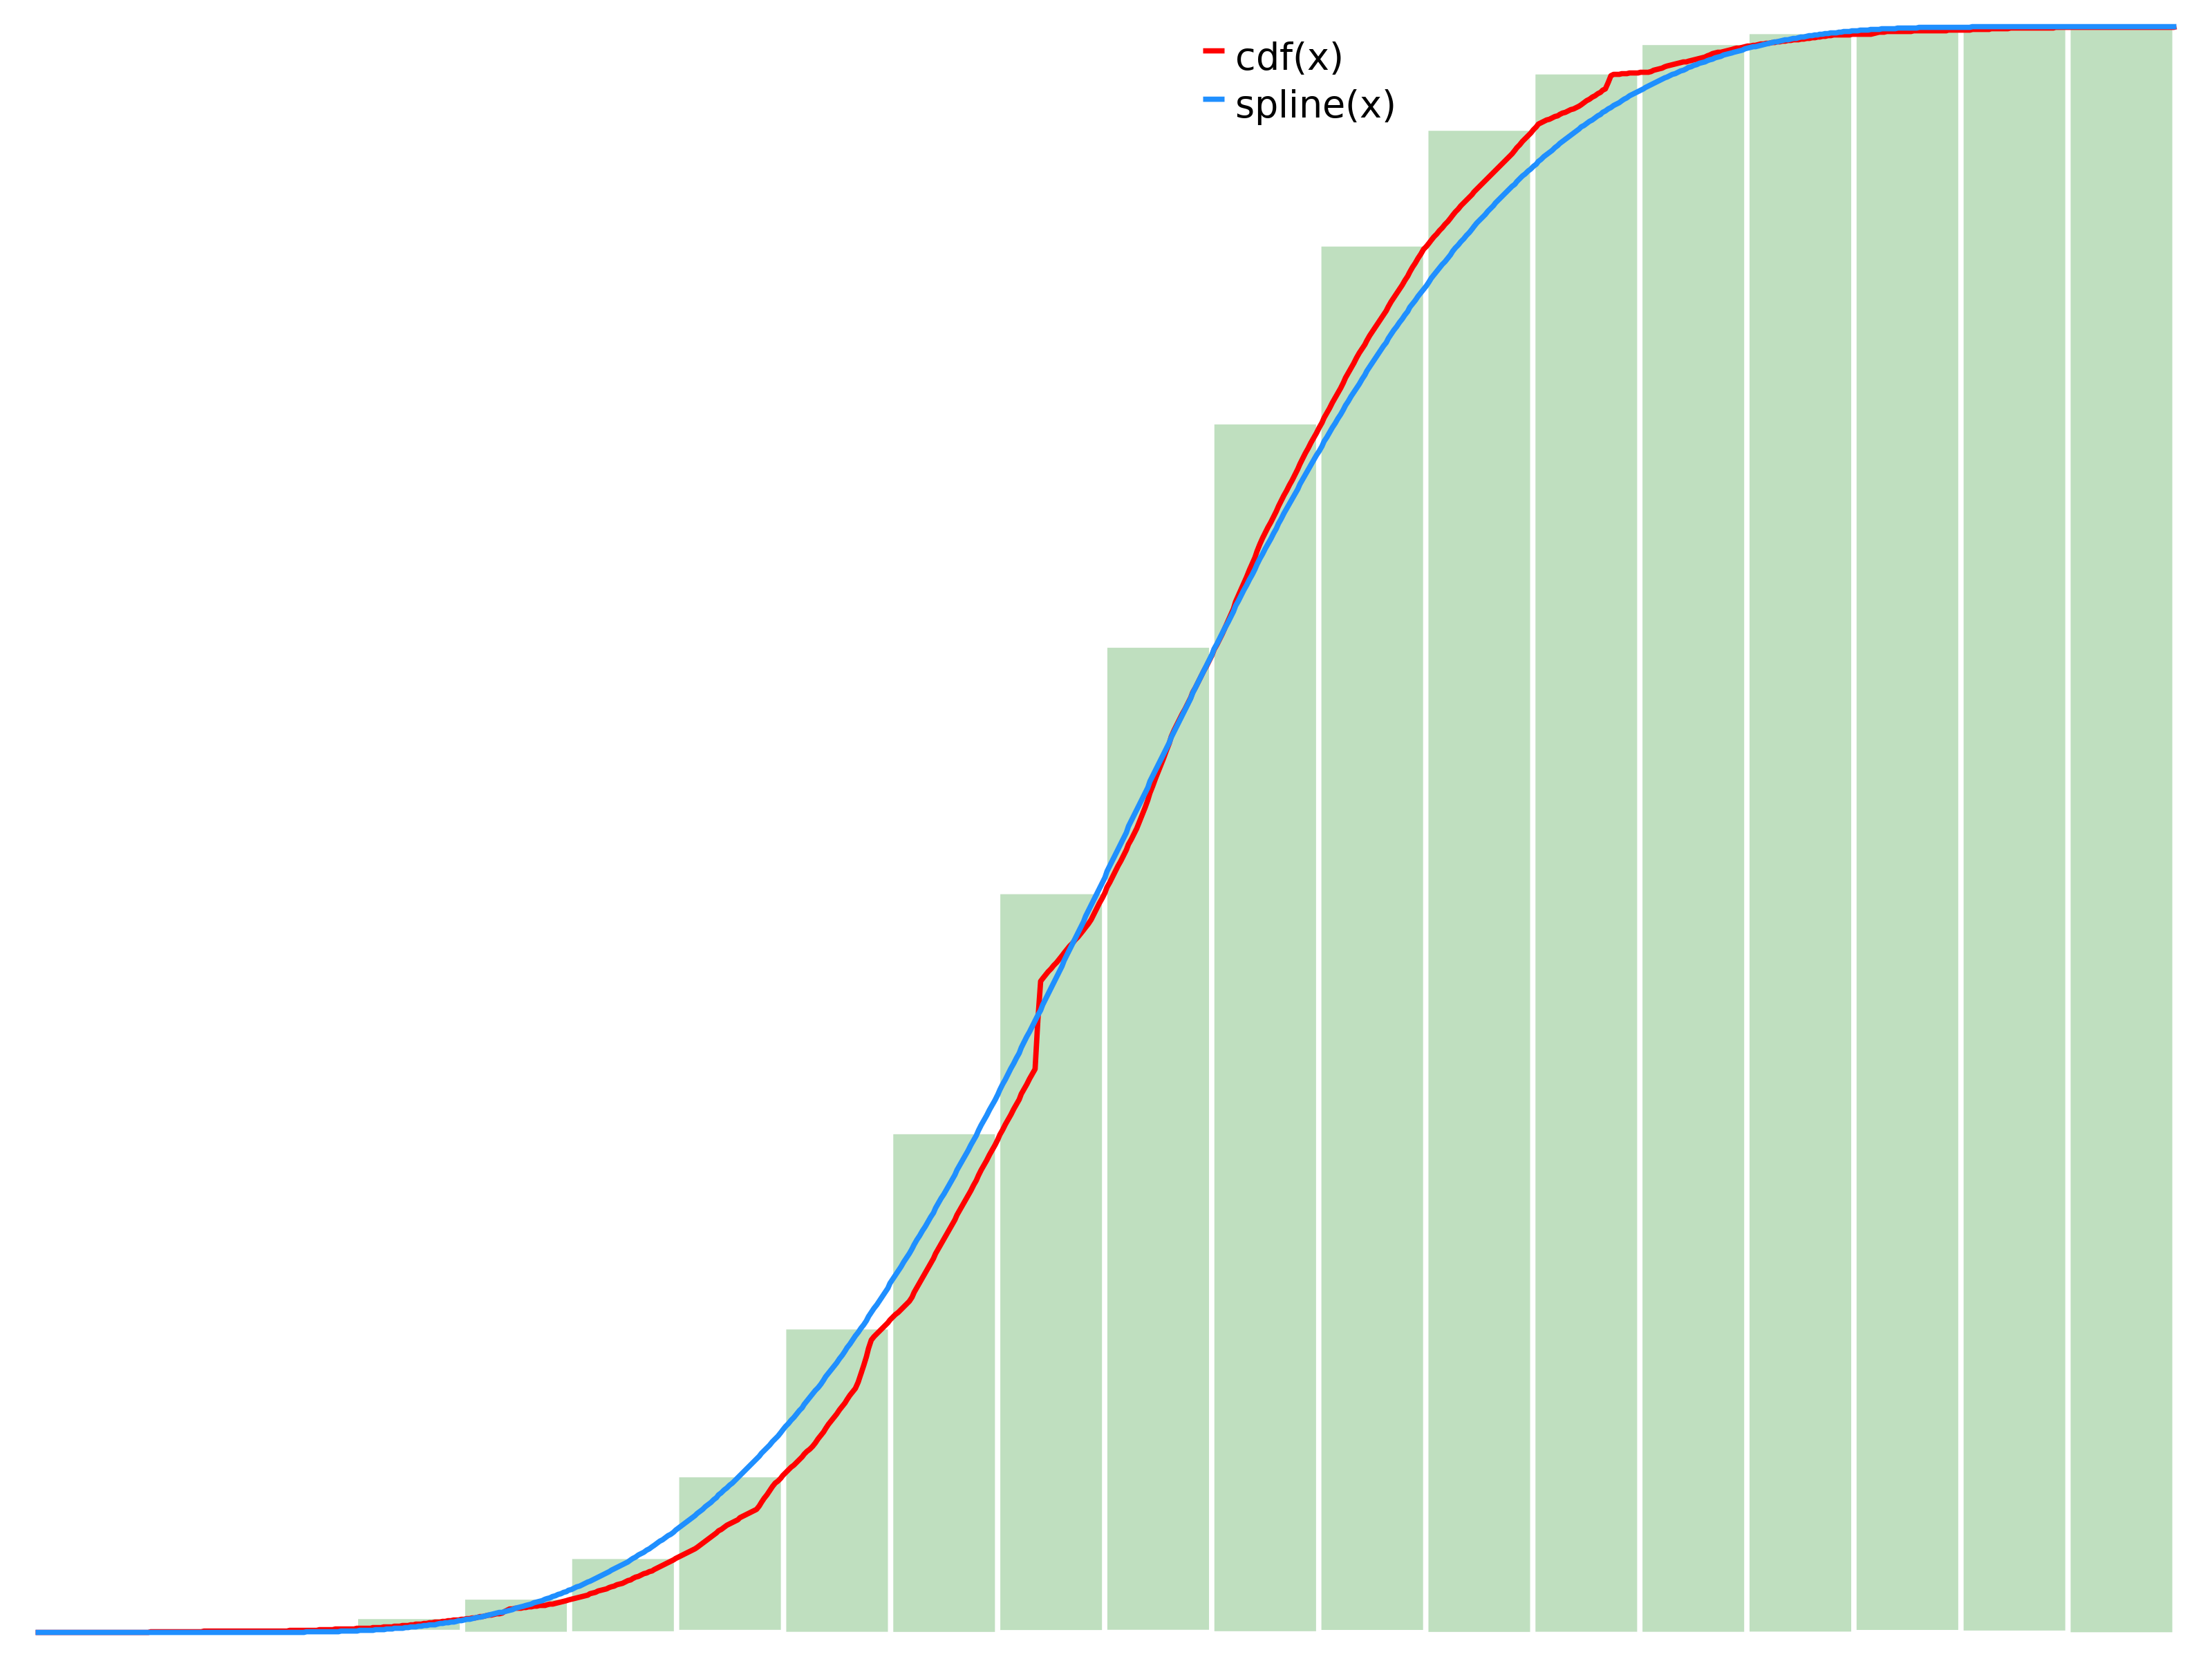

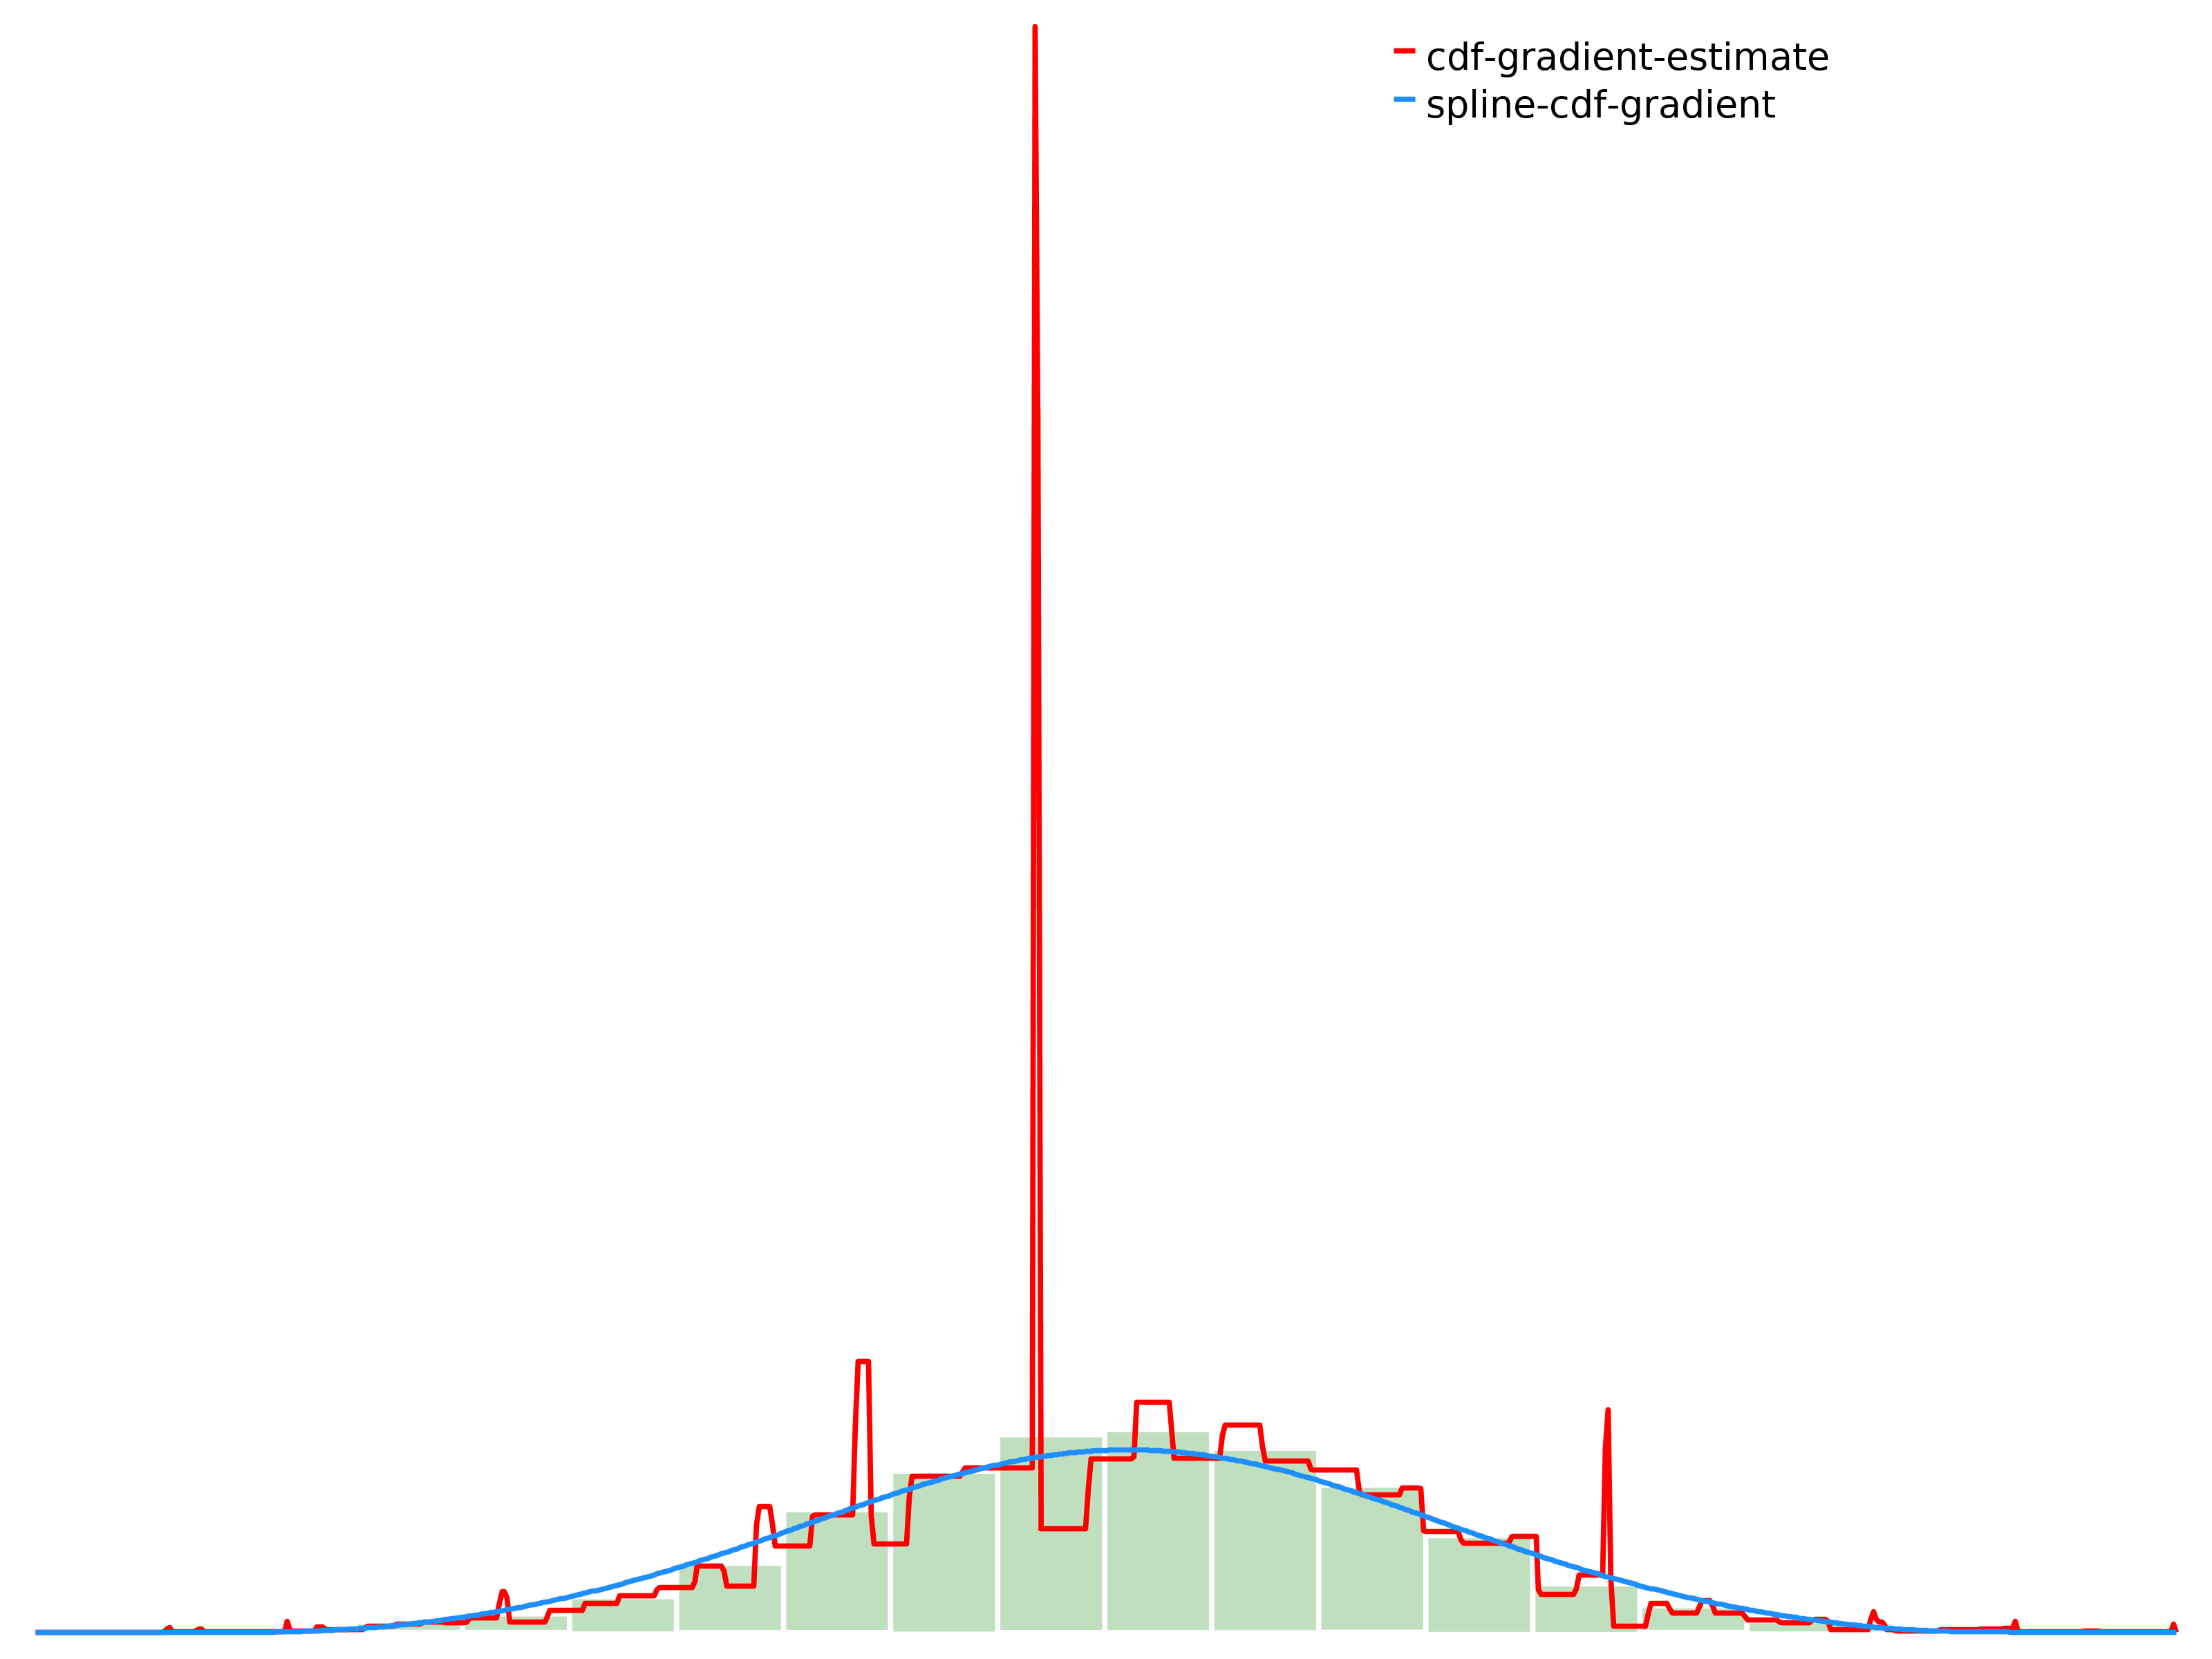

In [7]:
generateSpliningComparisons(new NormalDistribution())

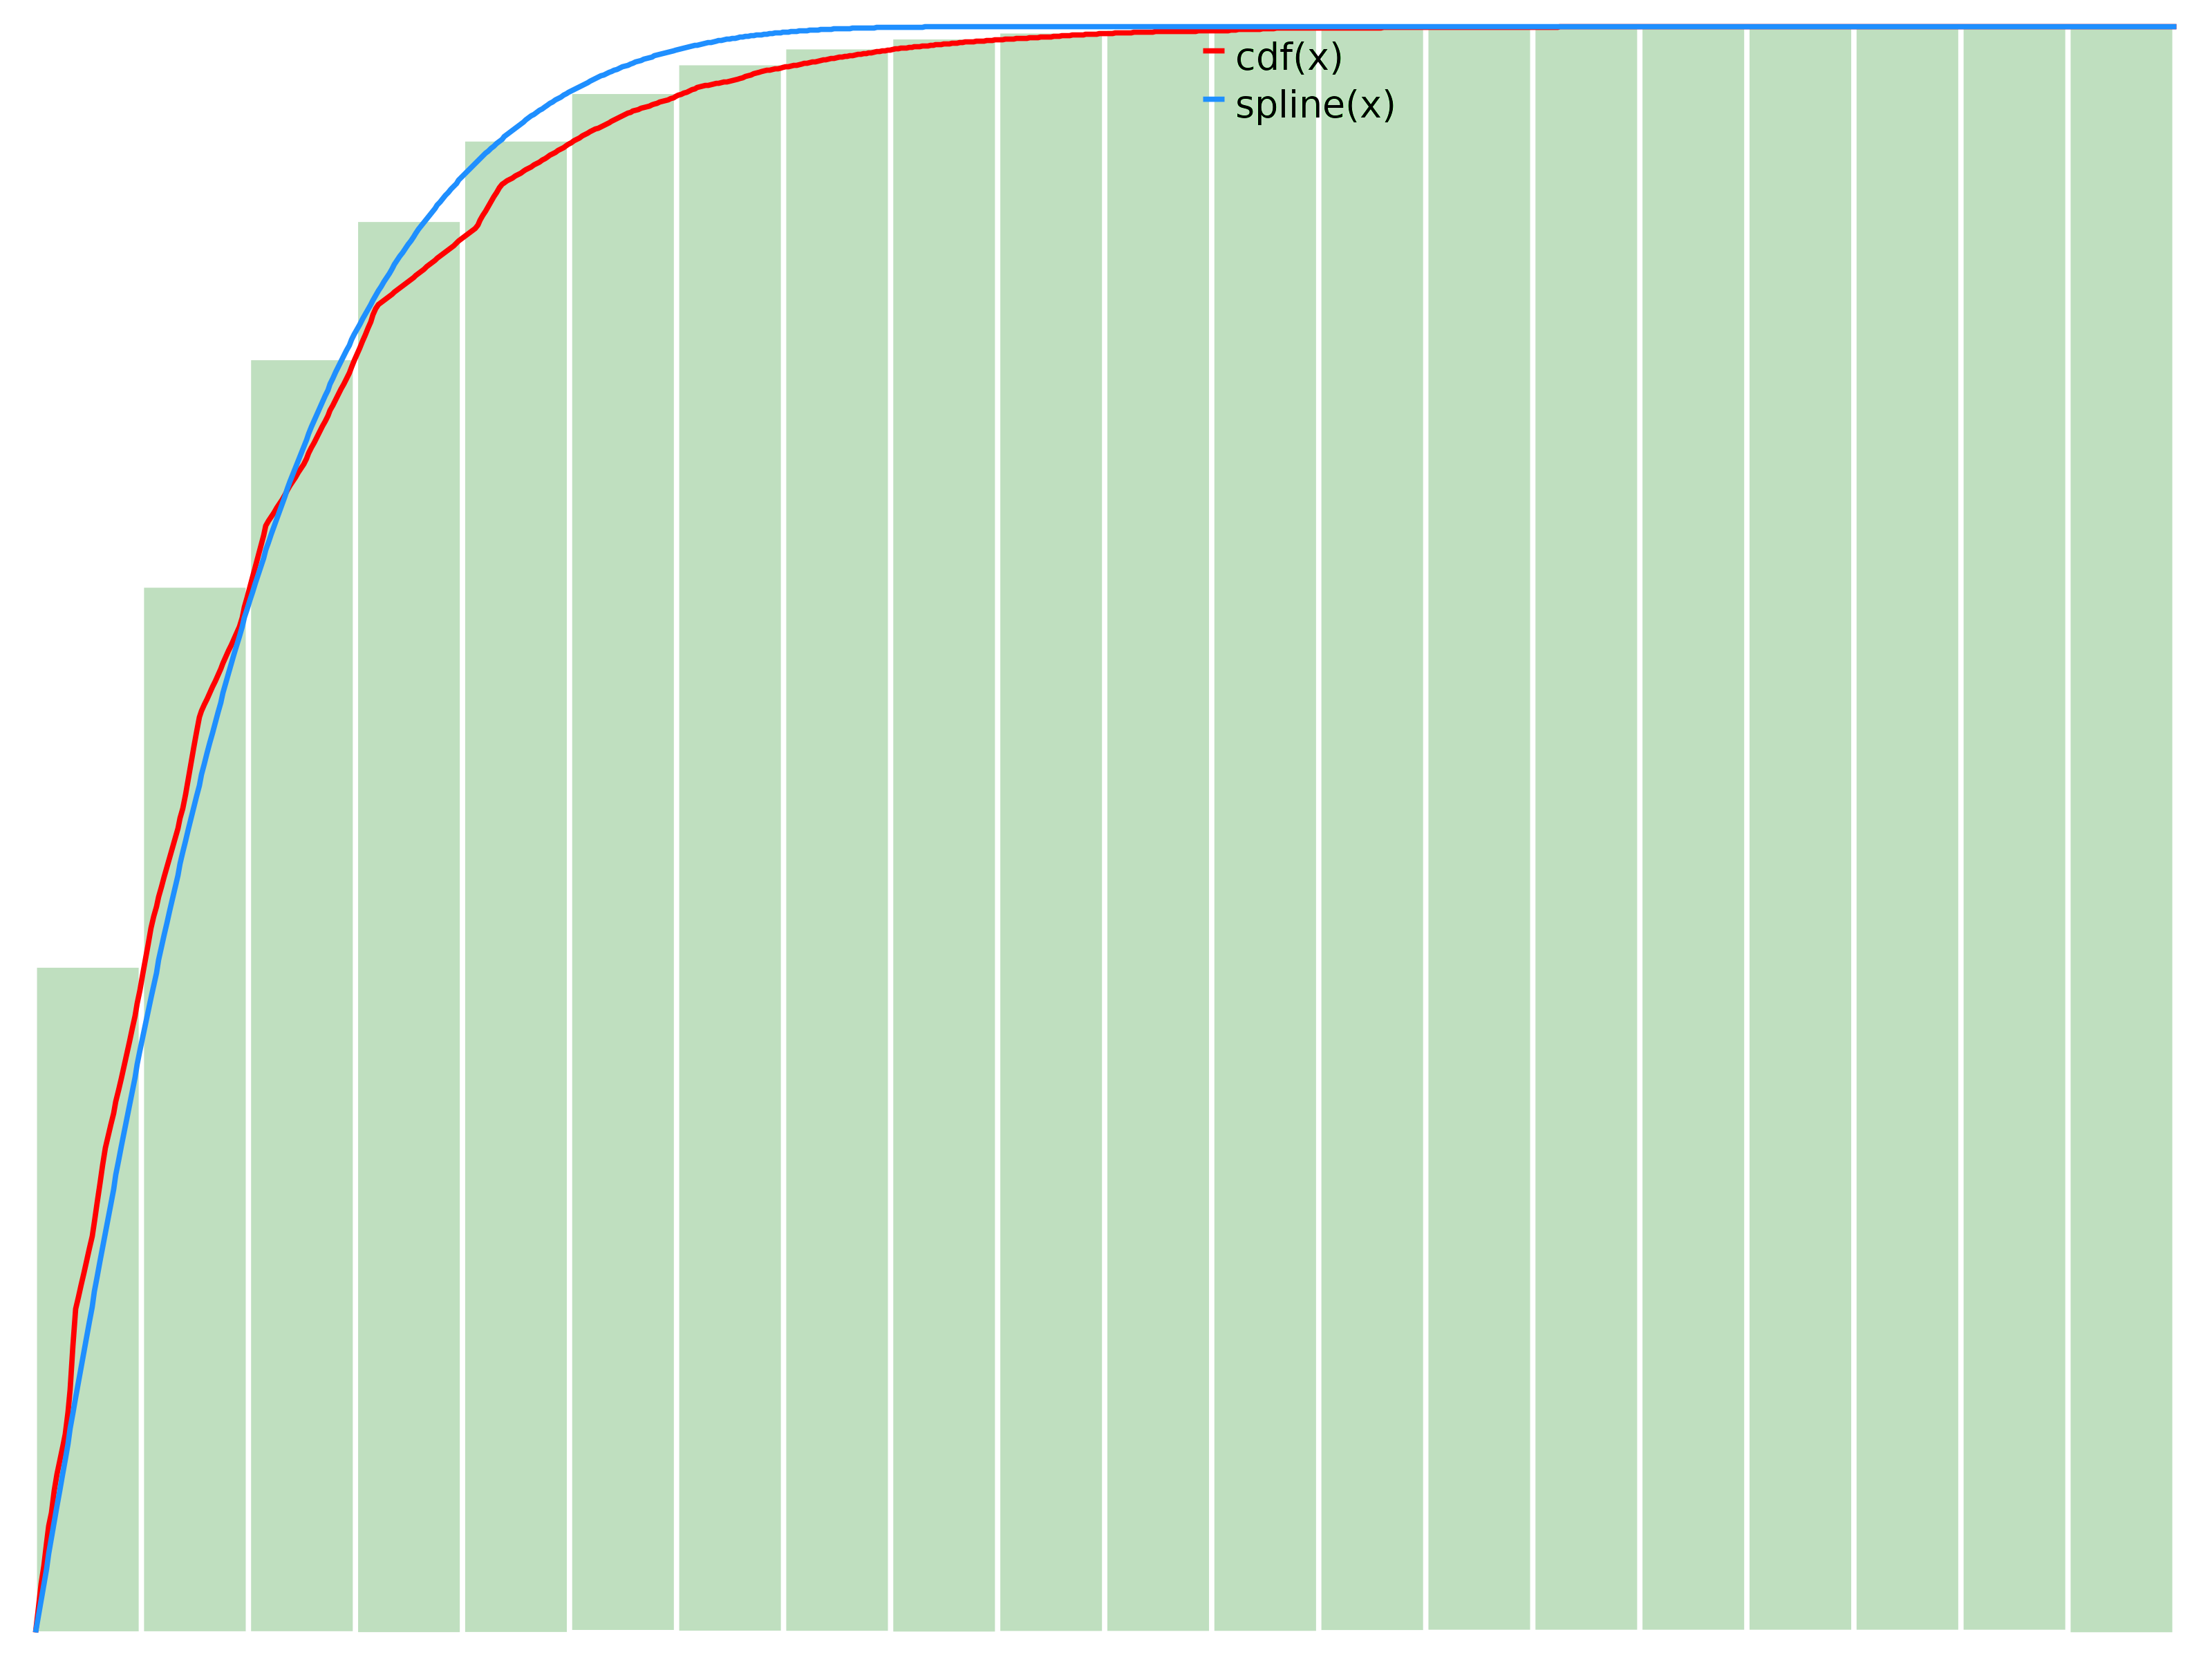

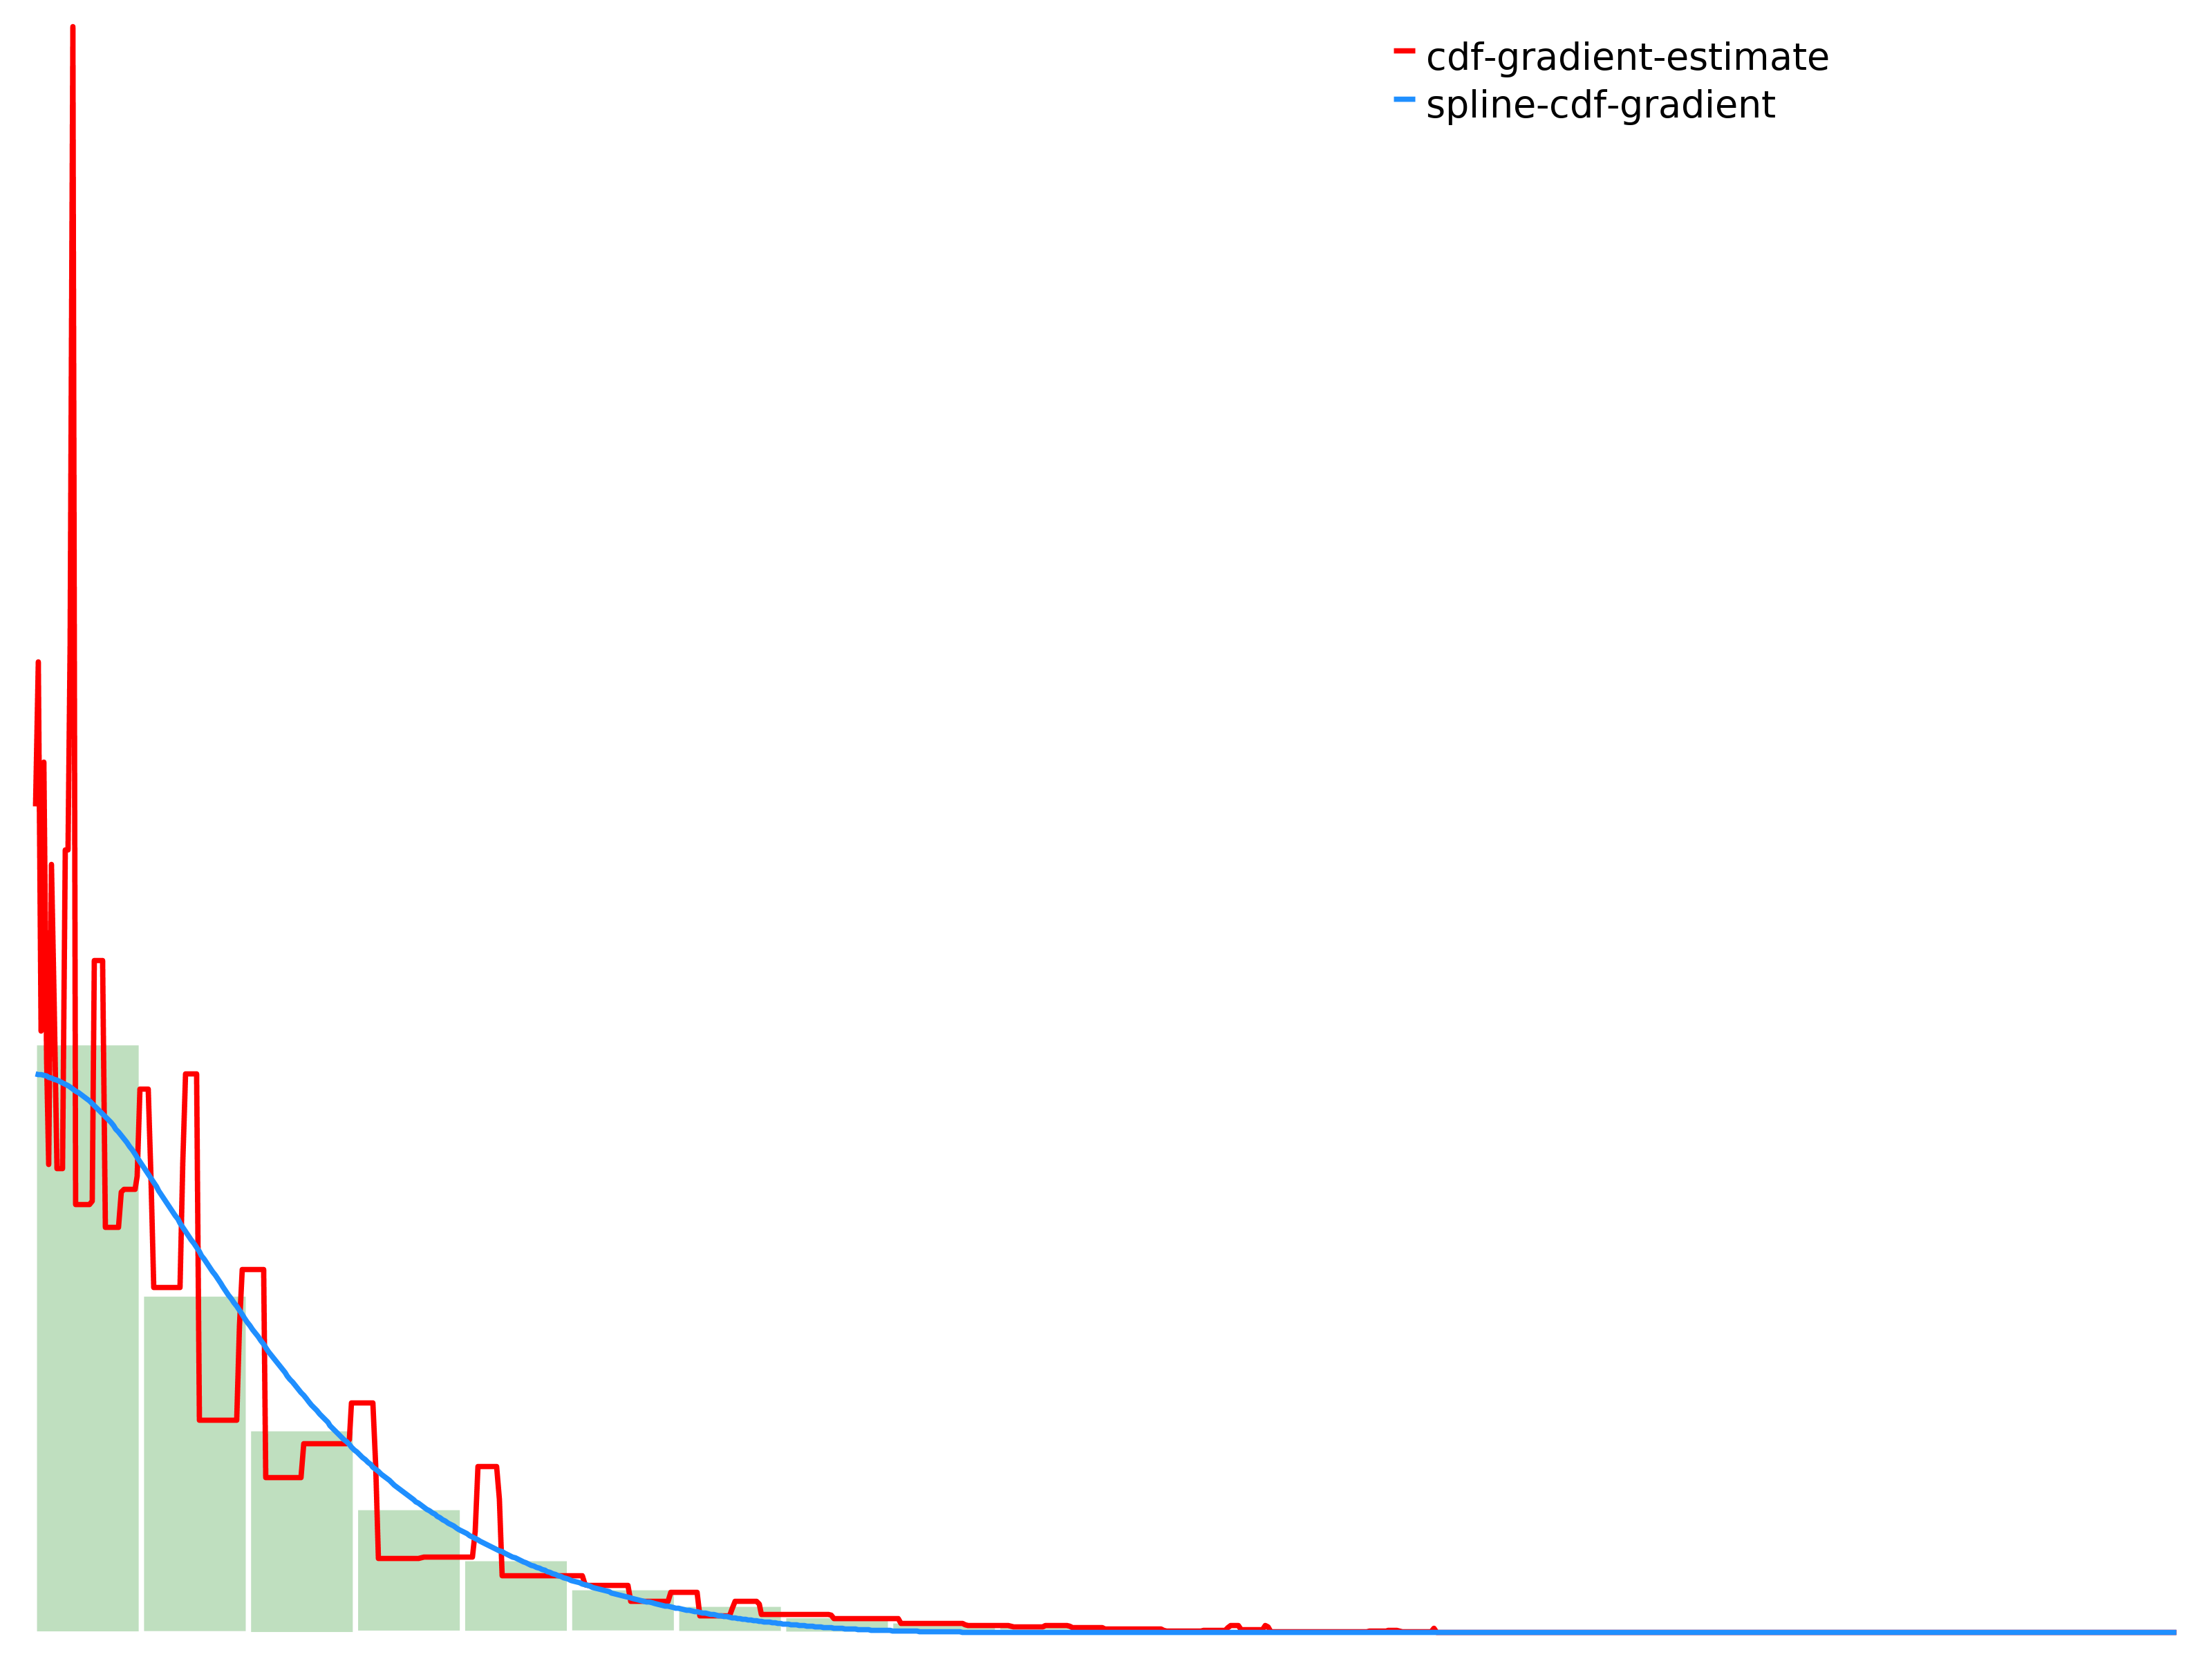

In [8]:
generateSpliningComparisons(new GammaDistribution(1.0, 1.0))

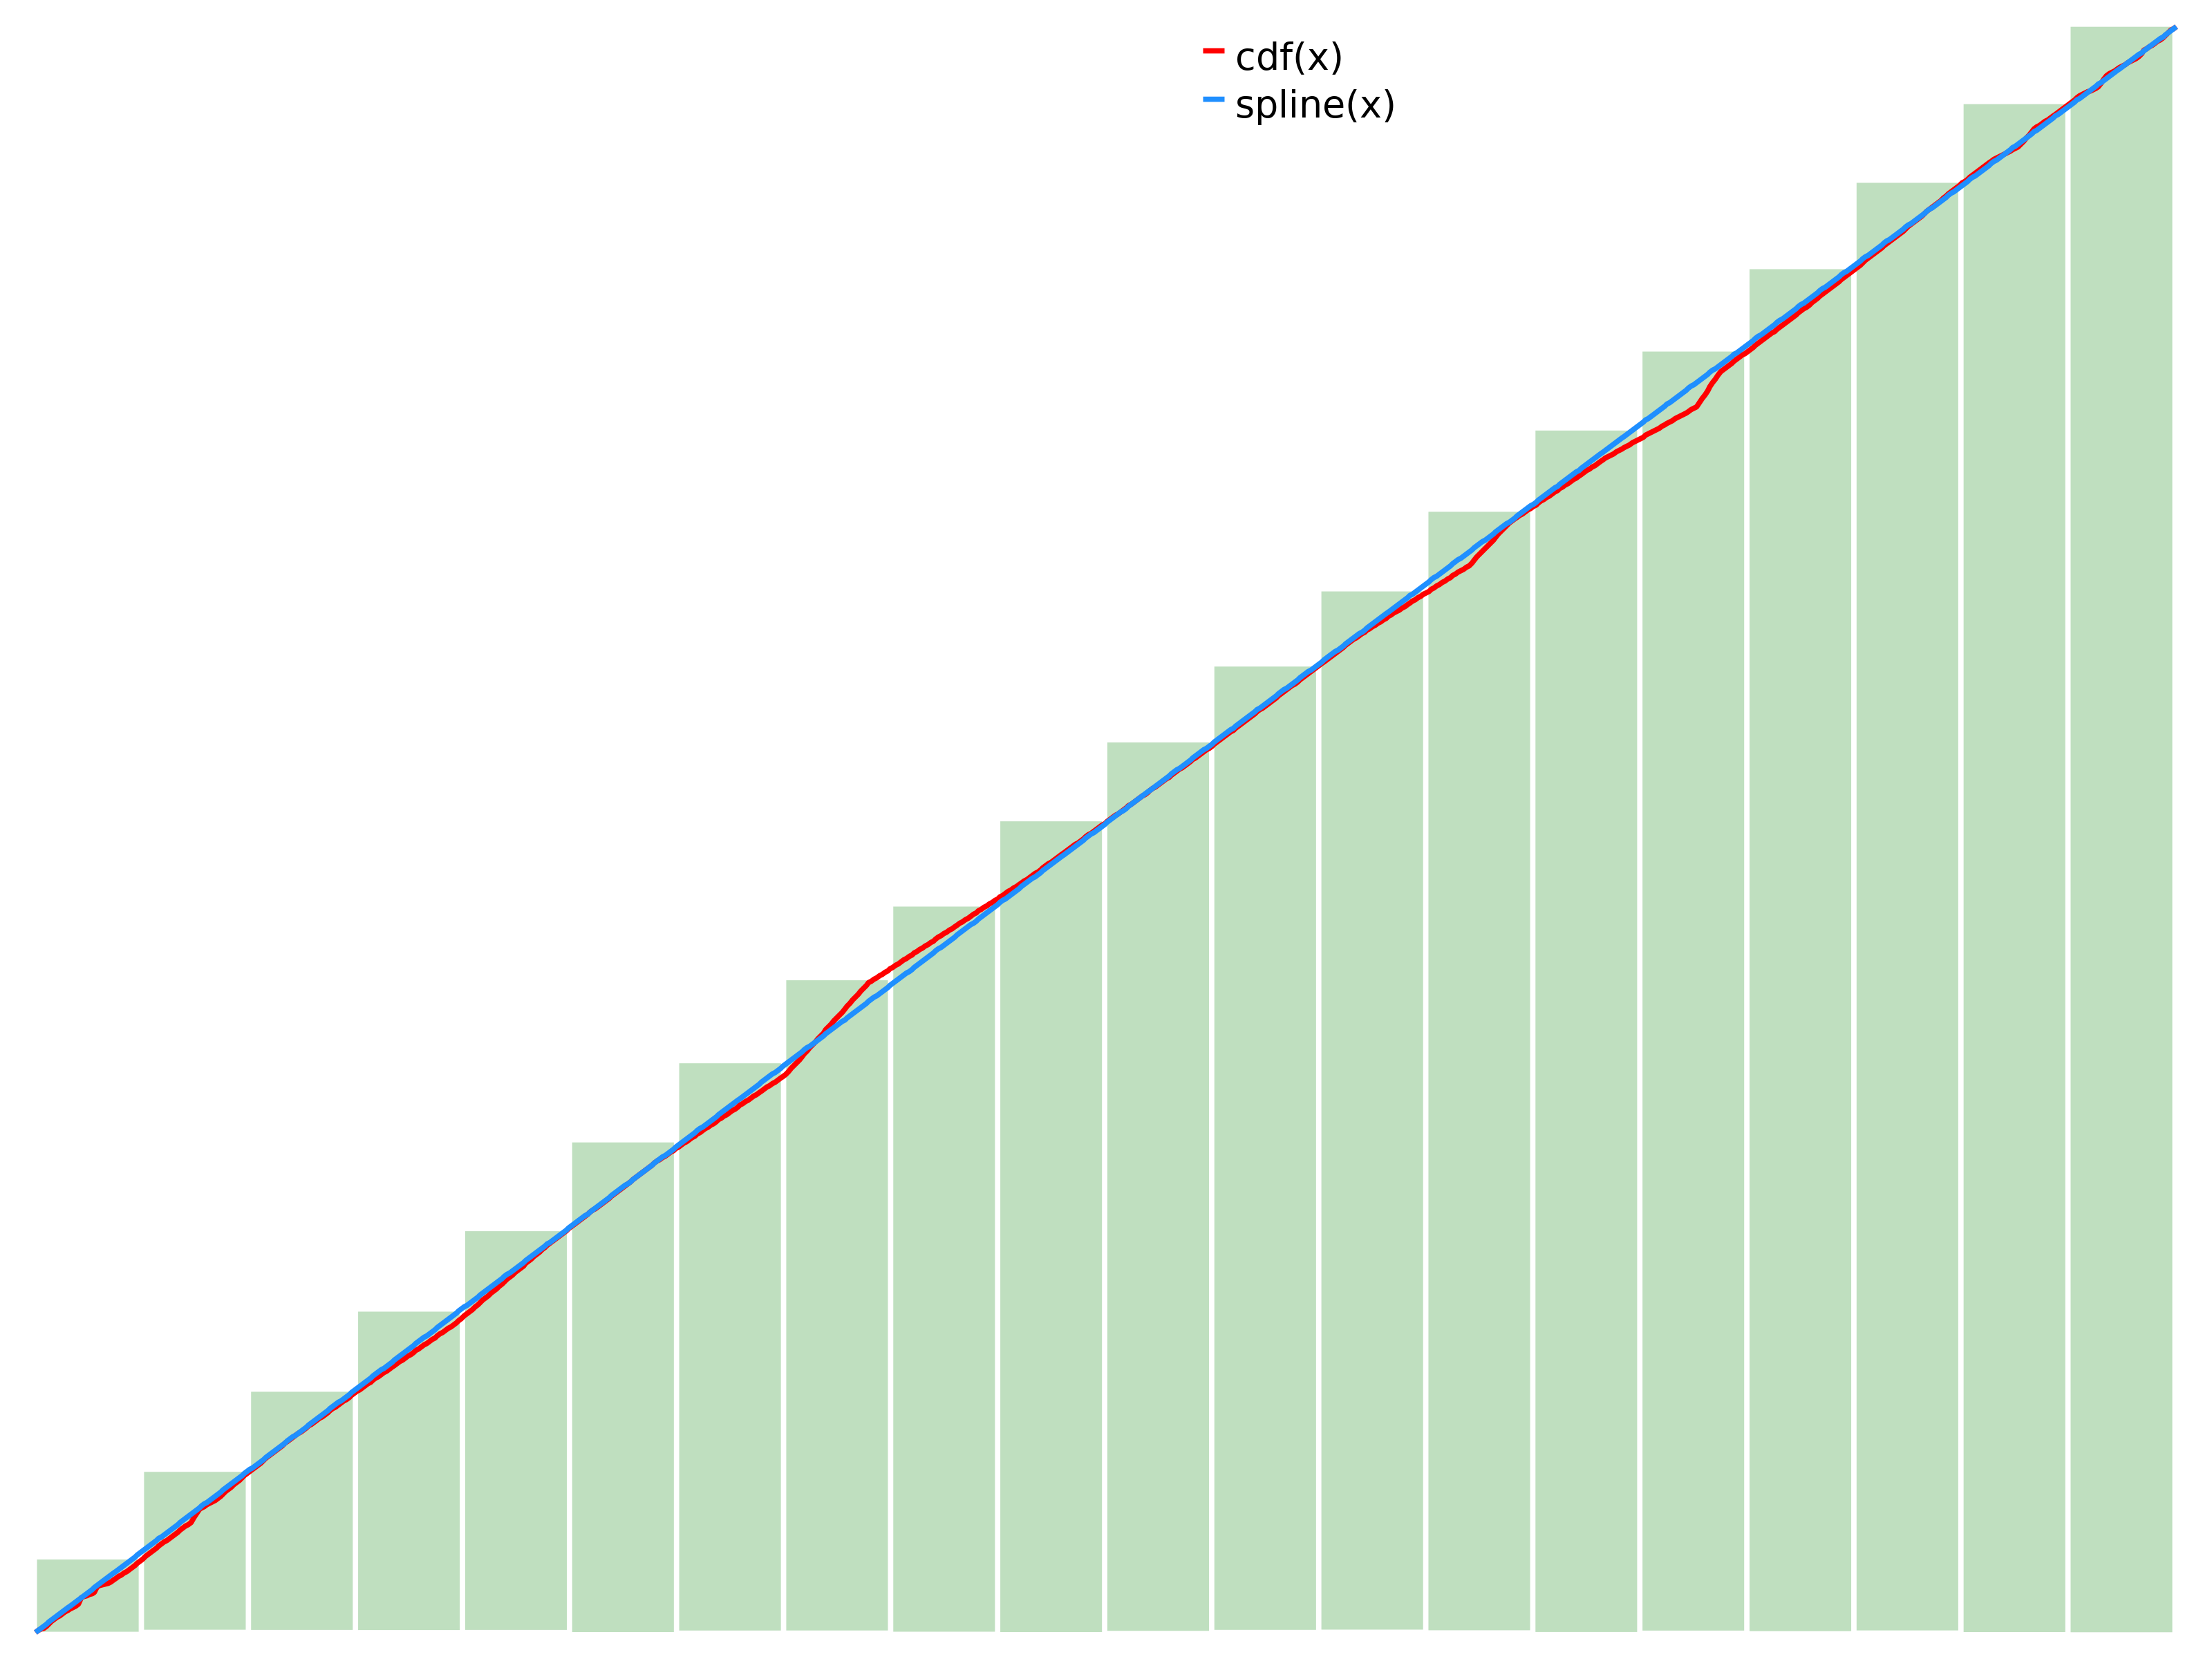

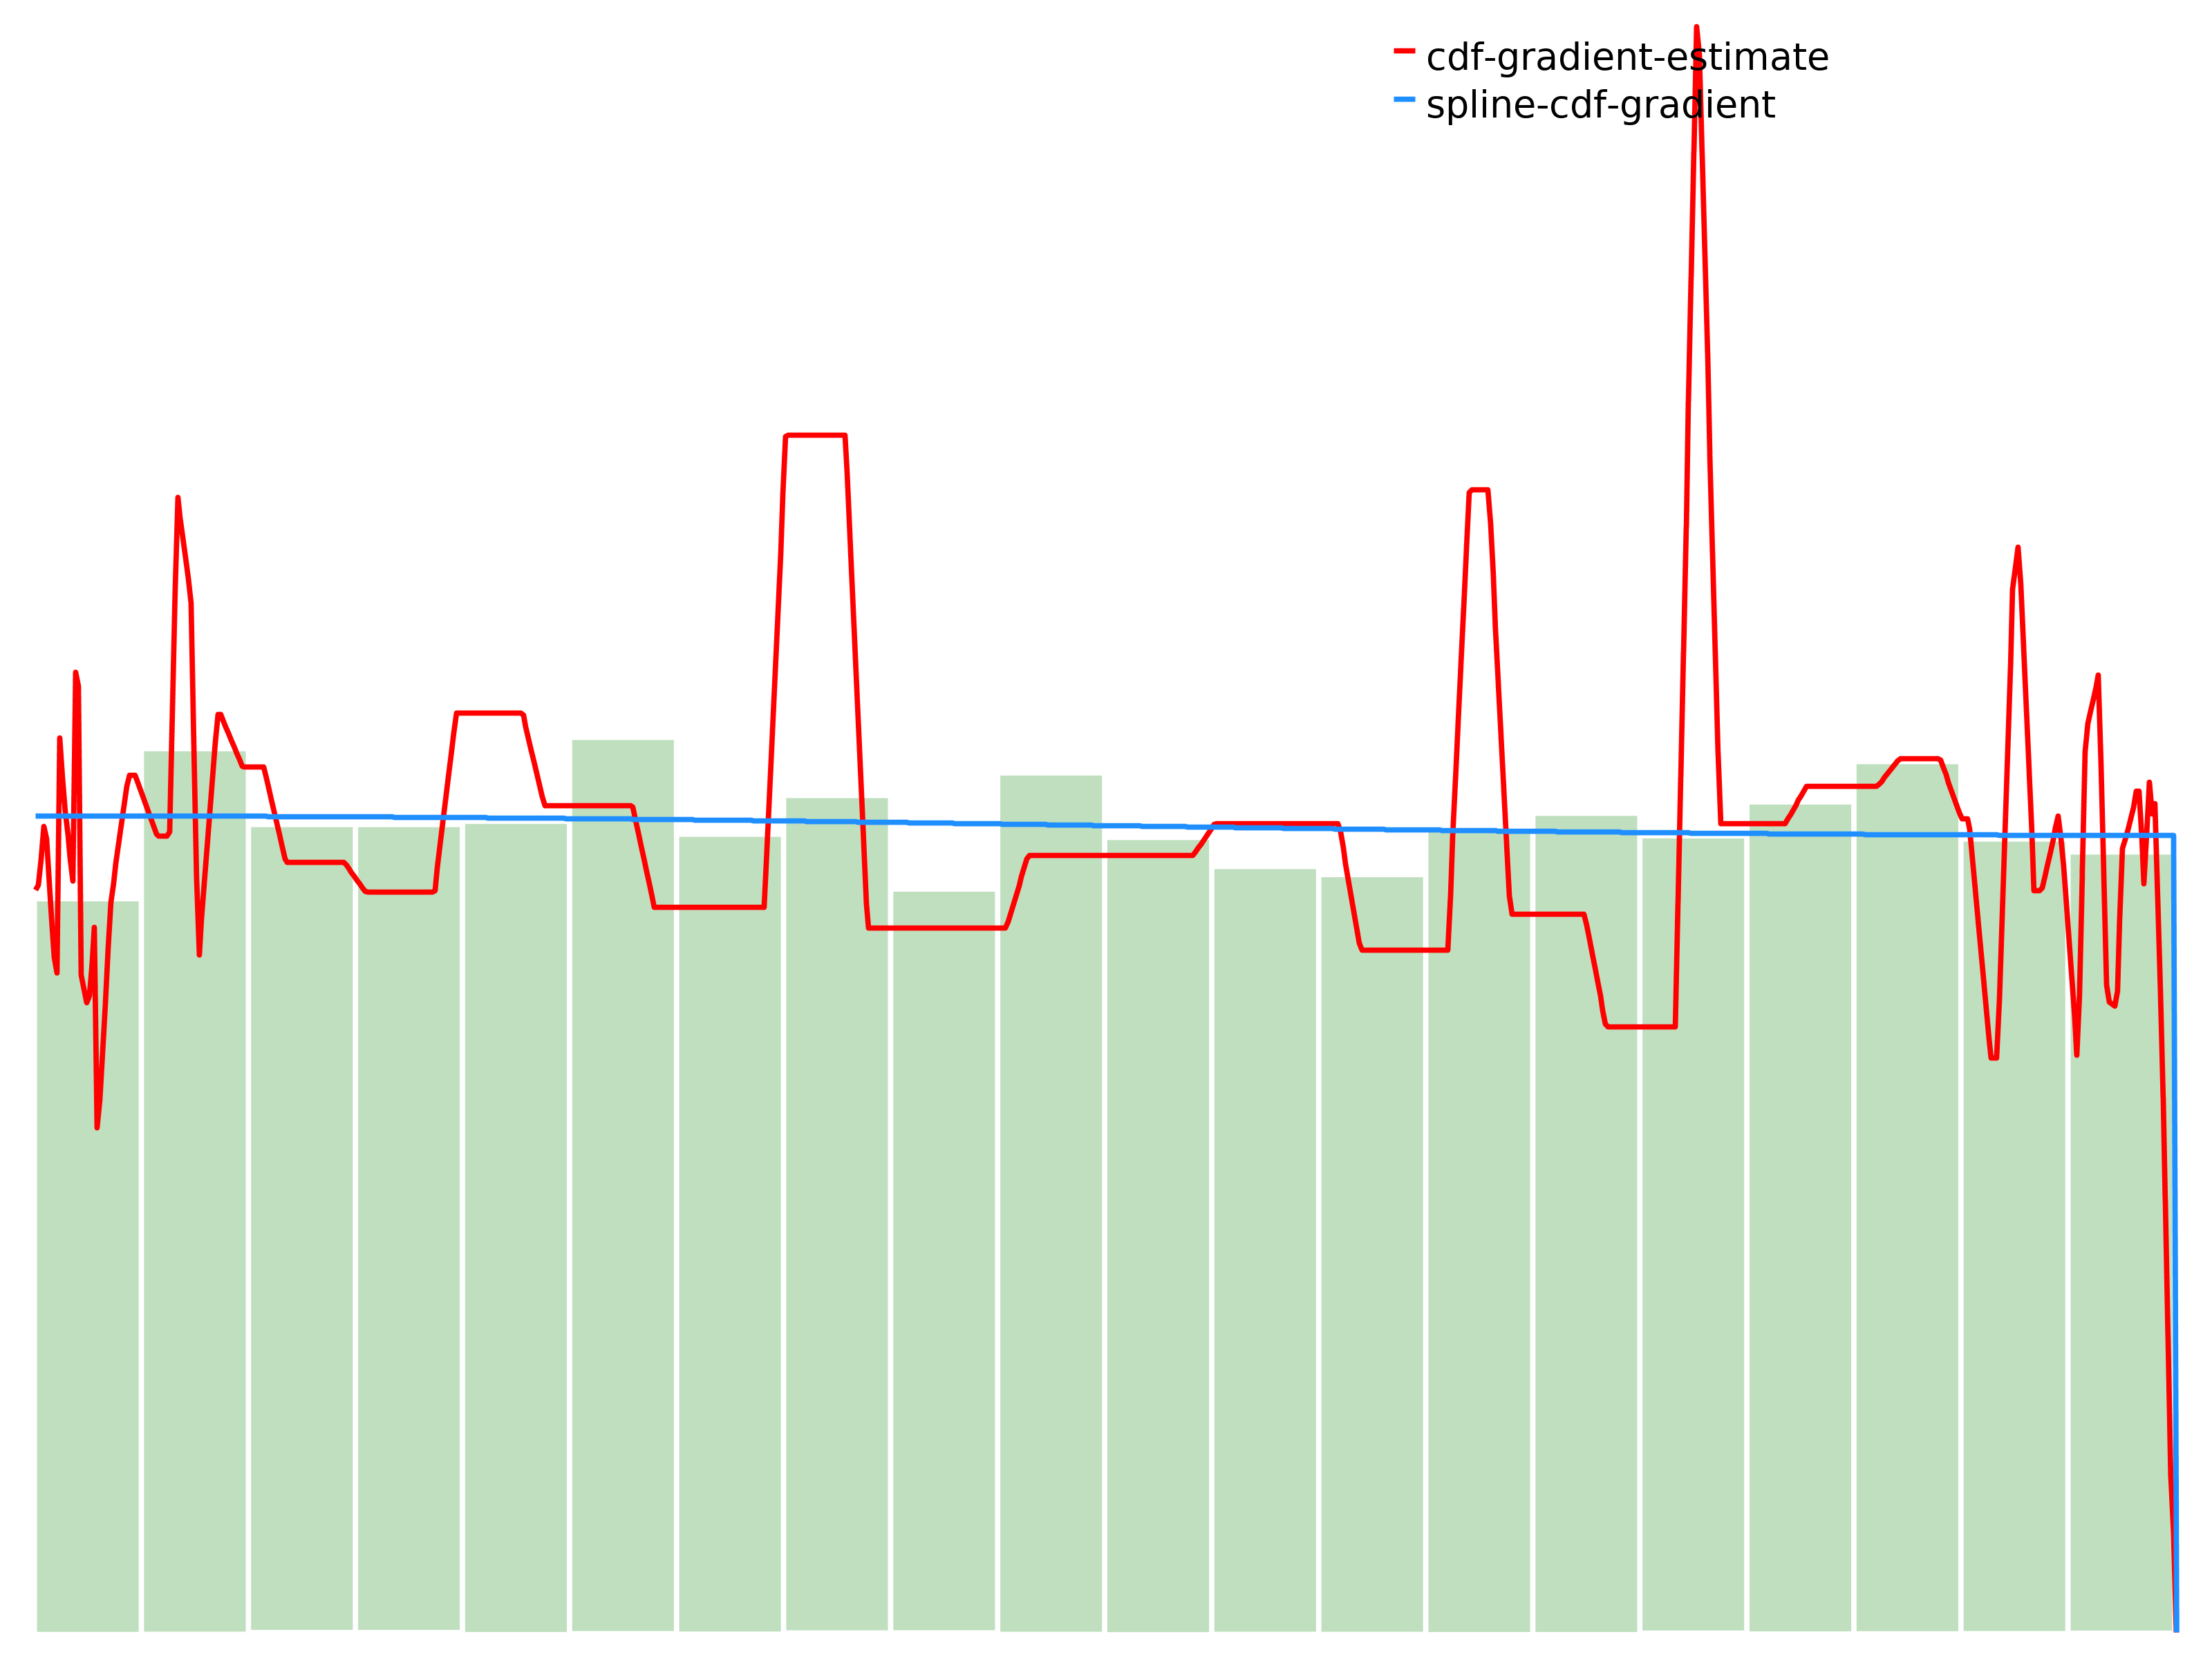

In [9]:
generateSpliningComparisons(new UniformRealDistribution(0.0, 1.0))